# Импорт библиотек и зависимостей

In [27]:
# !pip install git+https://github.com/tensorflow/examples.git
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix # декодер для upsampling
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Анализ данных и препроцессинг

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True) # загружаем датасет

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling oxford_iiit_pet-train.tfrecord...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling oxford_iiit_pet-test.tfrecord...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /Users/mikhailzaytsev/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [10]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/Users/mikhailzaytsev/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
 

In [6]:
def normalize(input_image, input_mask):
    """Функция для нормализации изображения и приведения индексов маски к {0,1,2} вместо {1,2,3}"""
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [8]:
# @tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128)) # масштабируем картинку
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128)) # масштабируем маску

#     if tf.random.uniform(()) > 0.5:
#         input_image = tf.image.flip_left_right(input_image)
#         input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask) # нормализуем изображения
    return input_image, input_mask

In [9]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [17]:
# зададим параметры для формирования датасетов
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

# пайплайны для загрузки батчей
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [22]:
def show_img(list_):
    """Функция для отображения картинки, маски и предсказания"""
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    plt.figure(figsize=(10, 10))
    for i in range(len(list_)):
        plt.subplot(1, len(list_), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(list_[i]))
        plt.axis('off')
    plt.show()

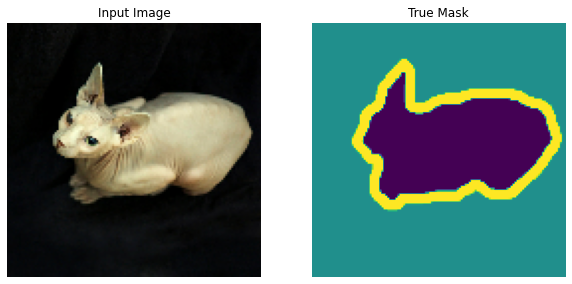

In [23]:
for image, mask in train.take(1): # возьмем один элемент
    sample_image, sample_mask = image, mask
show_img([sample_image, sample_mask]) # отобразим элемент

# Построение модели

Будем использовать U-Net образную архитектуру

In [24]:
OUTPUT_CHANNELS = 3

In [28]:
base_model = keras.applications.MobileNetV2(input_shape=[128, 128, 3], 
                                            include_top=False) # загружаем претренированную модель

# Будем использовать промежуточные выходы с этих слоев
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

encoder = keras.Model(inputs=base_model.input, outputs=base_model_outputs) # модель encoder
encoder.trainable = False #  модель не обучается

In [29]:
decoder = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
] # модель декодера

In [33]:
# формируем полную модель
def unet_model(output_channels):
    inputs = keras.layers.Input(shape=[128, 128, 3]) # вход в encoder

    skips = encoder(inputs) # skip-connections
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling и объеденение с skip-connections
    for up, skip in zip(decoder, skips):
        x = up(x)
        concat = keras.layers.Concatenate()
        x = concat([x, skip]) # объединяем выходы слоев

    last = keras.layers.Conv2DTranspose(output_channels, 
                                        kernel_size=3, 
                                        strides=2,
                                        padding='same')  # Обратная конволюция 64x64 -> 128x128
    x = last(x) # выходной слой
    return keras.Model(inputs=inputs, outputs=x)

In [34]:
model = unet_model(OUTPUT_CHANNELS) # определяем модель
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) # задаем параметры

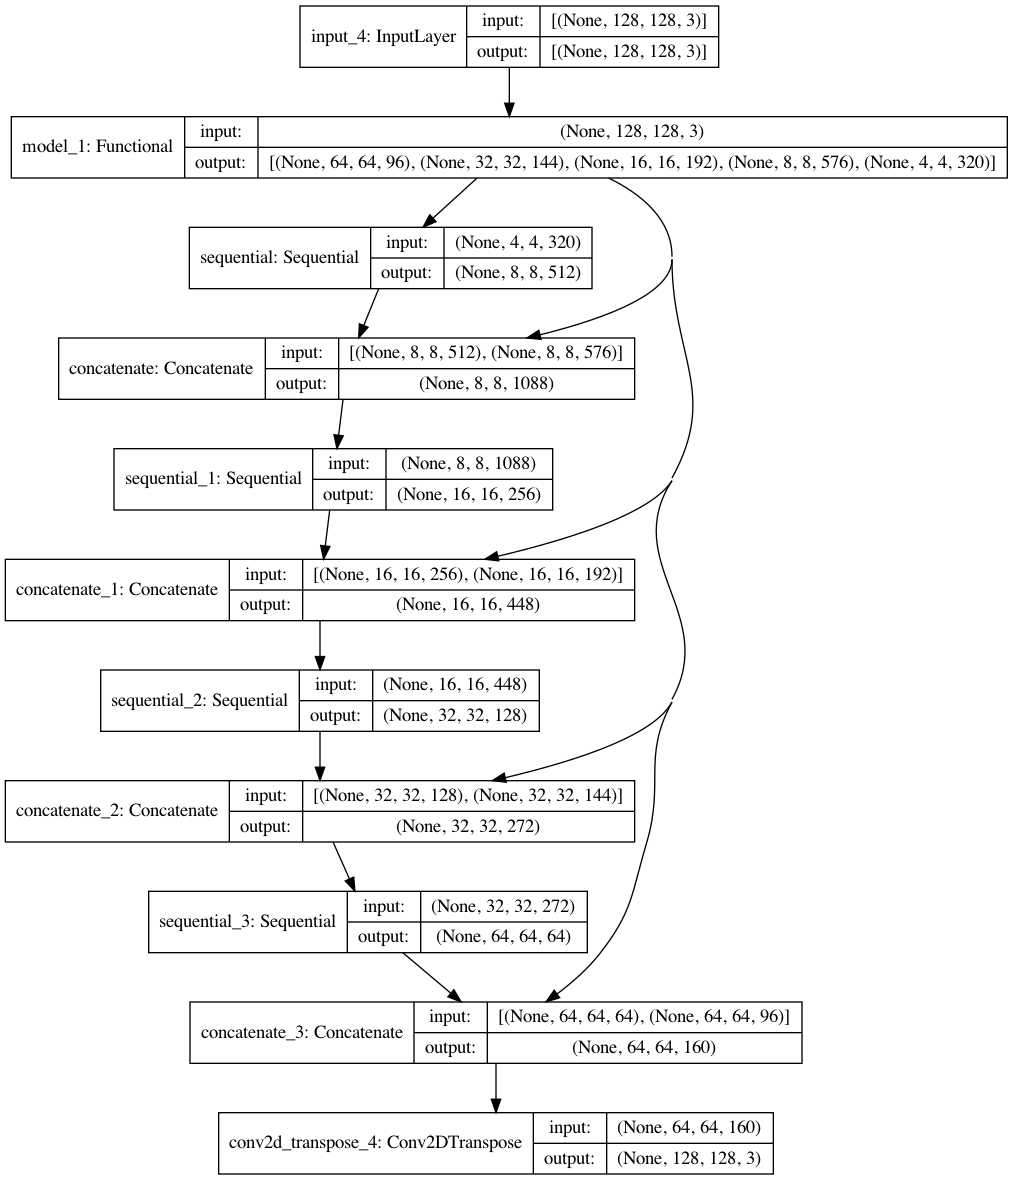

In [35]:
tf.keras.utils.plot_model(model, show_shapes=True) # архитектура модели

Посмотрим на предсказания модели без тренировки:

In [38]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis] # расширяем размерность
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))]) # расширяем размерность

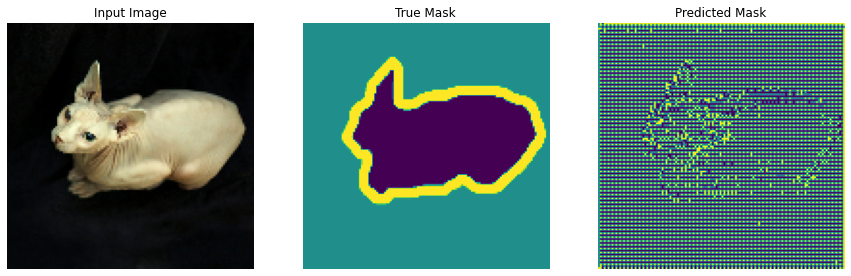

In [44]:
show_predictions()

Тренируем модель:

In [49]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEPS,
                    validation_data=test_dataset
                    )

Epoch 1/10
57/57 [==============================] - 112s 2s/step - loss: 0.3851 - accuracy: 0.8492 - val_loss: 0.4074 - val_accuracy: 0.8528
Epoch 2/10
57/57 [==============================] - 112s 2s/step - loss: 0.2929 - accuracy: 0.8800 - val_loss: 0.3133 - val_accuracy: 0.8754
Epoch 3/10
57/57 [==============================] - 110s 2s/step - loss: 0.2711 - accuracy: 0.8873 - val_loss: 0.2980 - val_accuracy: 0.8792
Epoch 4/10
57/57 [==============================] - 108s 2s/step - loss: 0.2568 - accuracy: 0.8921 - val_loss: 0.2907 - val_accuracy: 0.8805
Epoch 5/10
57/57 [==============================] - 107s 2s/step - loss: 0.2499 - accuracy: 0.8945 - val_loss: 0.2726 - val_accuracy: 0.8899
Epoch 6/10
57/57 [==============================] - 110s 2s/step - loss: 0.2396 - accuracy: 0.8984 - val_loss: 0.2701 - val_accuracy: 0.8908
Epoch 7/10
57/57 [==============================] - 106s 2s/step - loss: 0.2357 - accuracy: 0.8993 - val_loss: 0.2746 - val_accuracy: 0.8909
Epoch 8/10
57

Посмотрим как сегментации кошки выглядит теперь:

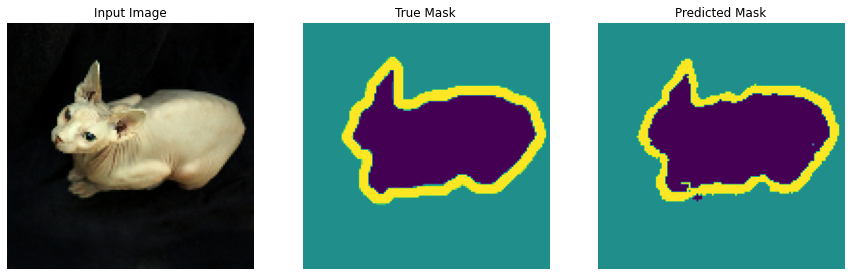

In [55]:
show_predictions()

Сделаем предсказания на тестовой выборке:

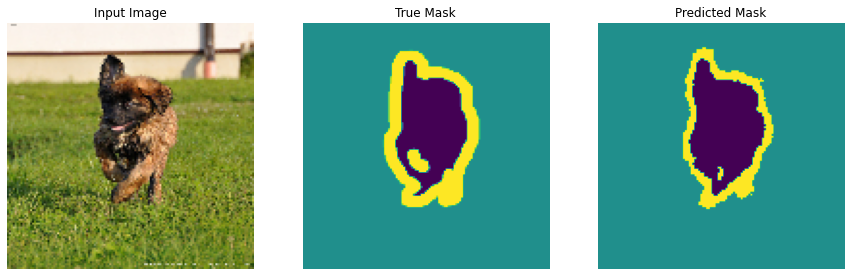

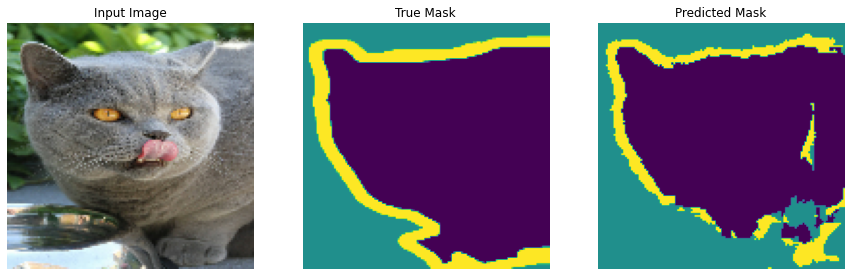

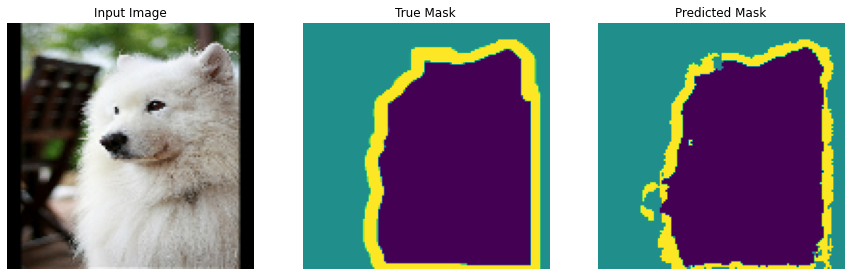

In [54]:
show_predictions(test_dataset, 3)